# Data descrition
The length of all BikeNYC is 4392. From 01/04/2014 0:00- 30/09/2014 24:00
The length of training data sequence is 4152 with the shape (4152, 2, 16, 8), for testing data sequence is 240 with shape of (240, 2, 16, 8).

**NB:** The data sequence cannot be directly used in paper. So as to fit training data into DeepST. We must preprocess data (4152, 2, 16, 8) with hyparameters into three  parts, i.e., X_Closeness shape:  (3720, 6, 16, 8) X_Period shape:  (3720, 8, 16, 8) X_Trend shape:  (3720, 8, 16, 8) Y shape: (3720, 2, 16, 8)

(The hyparameters are TrendInterval=7, len_trend=4, PeriodInterval=1, len_period=4, len_closeness=3, self.T=24.)

# Why length changes from 4392 to 4152?
Because, 4392-4152 == 240, which is used for testing. 

# Why 3720, why 3480?
Because, as we know: 
1. The data timestamp is with the unit of 1 hour. 
2. At the same time, we know the longest interval length will be decided by the parameters of TrendInterval x len_trend x 24 == 672. Hence the first 672 data sequence can only be used as input, but not as output (label). That's to say the start labeled data are is the number of 4392-672 == 3720, among them 240 for testing, so 3480 for training. 

# Data maybe not suitable for Deep Learning. Why?
We can see that the size of trainging data are only the number of 3480. These data look very small for DL, and violate the rule saying **Feed Big Data** into deep learning. Otherwise, overfitting may be happenning!! (You can imagine the image data set call ImageNet has one million training images.) But why DeepST implemented almost satisfied? One possible reason is it is a regression task compared to ImageNet Classification task. 
Here is the question: **If we better use our data, how much the improvment space are?**

# How to better use our data?
Though DeepST has a great behavor than other benchmarks. We always think there could be a big improvement and wanna do experiments to verify. The key problem existing is that DeepST may take in too much noise data! Why?
At the first glance, DeepST considers the factors including Closeness, Period and Trend which is very resonable. But please think carefully, in the real-time citywide prediction problem, dose the factors Period and Trend play important roles??! No, I don't think so. In a real-time variation situation, what the most important information is only the Closeness! Much more previous data only brings into much more noise. Just like the stock market, there are basicly two technology sect: Short Line and Long Line. Long Line pays more attention on a very long trend. Short Line thinks the price now is more influenced by just now! Which is better suitable for the real-time citywide problem. Below, we clear this point from the statistics and verify by experiments.

# We first reproduce the figure.
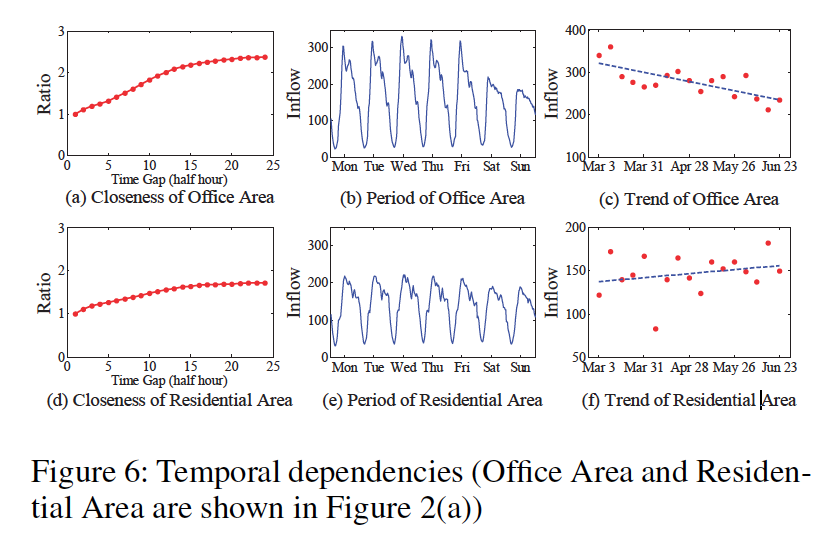

In [9]:
from __future__ import print_function
import os
import sys
import pickle
import time
import numpy as np
import h5py

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from deepst.models.STResNet import stresnet
from deepst.config import Config
import deepst.metrics as metrics
from deepst.datasets import BikeNYC
np.random.seed(1337)  # for reproducibility
import math

In [19]:
x=np.array([1,2,3,4,5])
y=x[1::2]
print(y)

[2 4]


In [2]:
# parameters
# data path, you may set your own data path with the global envirmental
# variable DATAPATH
DATAPATH = Config().DATAPATH
nb_epoch = 500  # number of epoch at training stage
nb_epoch_cont = 100  # number of epoch at training (cont) stage
batch_size = 32  # batch size
T = 24  # number of time intervals in one day

lr = 0.0002  # learning rate
len_closeness = 3  # length of closeness dependent sequence
len_period = 0  # length of peroid dependent sequence
len_trend = 0  # length of trend dependent sequence
nb_residual_unit = 4   # number of residual units

nb_flow = 2  # there are two types of flows: new-flow and end-flow
# divide data into two subsets: Train & Test, of which the test set is the
# last 10 da ys
days_test = 10
len_test = T * days_test
map_height, map_width = 16, 8  # grid size
# For NYC Bike data, there are 81 available grid-based areas, each of
# which includes at least ONE bike station. Therefore, we modify the final
# RMSE by multiplying the following factor (i.e., factor).
nb_area = 81
m_factor = math.sqrt(1. * map_height * map_width / nb_area)
print('factor: ', m_factor)
path_result = 'Test_RET'
path_model = 'Test_MODEL'
if os.path.isdir(path_result) is False:
    os.mkdir(path_result)
if os.path.isdir(path_model) is False:
    os.mkdir(path_model)

factor:  1.2570787221094177


In [8]:
print("loading data...")
# data_numbers=None will use all data, this could be very slowly.
# data_numbers=800 will use only 800 series for trying on small data.
X_train_ALL, X_test_ALL, X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = BikeNYC.load_data(
    T=T, nb_flow=nb_flow, len_closeness=len_closeness, len_period=len_period, len_trend=len_trend, len_test=len_test,
    preprocess_name='preprocessing.pkl', meta_data=True, data_numbers=1800 )

print("\n days (test): ", [v[:8] for v in timestamp_test[0::T]])

print('=' * 10)
print("compiling model...")
print(
    "**at the first time, it takes a few minites to compile if you use [Theano] as the backend**")
print('external_dim is:', external_dim)

loading data...
h5 data shape: (1800, 2, 16, 8)
h5 timestamps data shape: (1800,)
The first 3 timestamps are: [b'2014040101' b'2014040102' b'2014040103']
The Last 3 timestamps are: [b'2014061422' b'2014061423' b'2014061424']
incomplete days:  []
sequences of all data shape is: (1800, 2, 16, 8)
len_test is 240
sequences of data_train  shape:  (1560, 2, 16, 8)
min: 0.0 max: 237.0
length of data_all is 1
d len is (1800, 2, 16, 8)
[mmn] length is 1
length of data_all_mmn is 1
length of timestamps_all is 1
The last time stamp is 2014 6 14 23
Pandas Timestamp is [Timestamp('2014-06-14 23:00:00')]
TrendInterval is 7, len_trend is 0,             PeriodInterval is 1, len_period is 0,            ,len_closeness is 3, self.T is24
max i is: 3


ValueError: all the input arrays must have same number of dimensions

In [17]:
for x in X_train:
    print(x.shape)
print()
print(Y_train.shape)
# Closeness of Area Coordanate (1,1)

(3648, 4, 16, 8)
(3648, 6, 16, 8)
(3648, 6, 16, 8)
(3648, 8)

(3648, 2, 16, 8)


# Display the hot map on the same o'clock in continous days

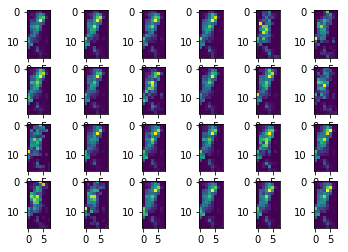

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
T = 24 # Cycle. In one day one cycle is 24 hours
oclock = 8 # time o'clock (1-24) on one day
fig = plt.figure(1)
len_display = 24 # The sequence number you wanna display.
for idx in range(len_display):  
    #print(timestamp_train[idx])
    ax = fig.add_subplot(4, 6, idx+1) # this line adds sub-axes
    ax.imshow(Y_train[oclock+idx*T][0]) # this line creates the image using the pre-defined sub axes

# Display the hot map on the same o'clock in continous weeks

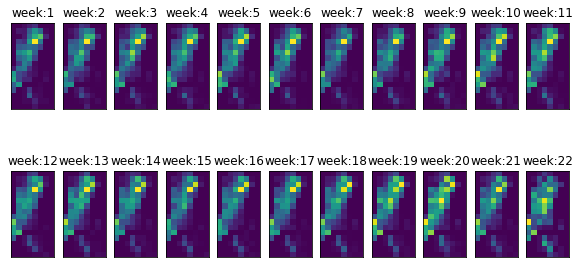

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
T = 24*7 # Cycle. In one week, one cycle is 24*7 hours
oclock = 8 # time o'clock (1-24) on one day
fig = plt.figure(figsize=(10,5))
len_display = 22 # The sequence number you wanna display.
for idx in range(len_display):  
    #print(timestamp_train[idx])
    ax = fig.add_subplot(2, 11, idx+1) # this line adds sub-axes
    ax.set_title('week:'+str(idx+1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(Y_train[oclock+idx*T][0]) # this line creates the image using the pre-defined sub axes

# Display the hot map on the same o'clock in continous hours

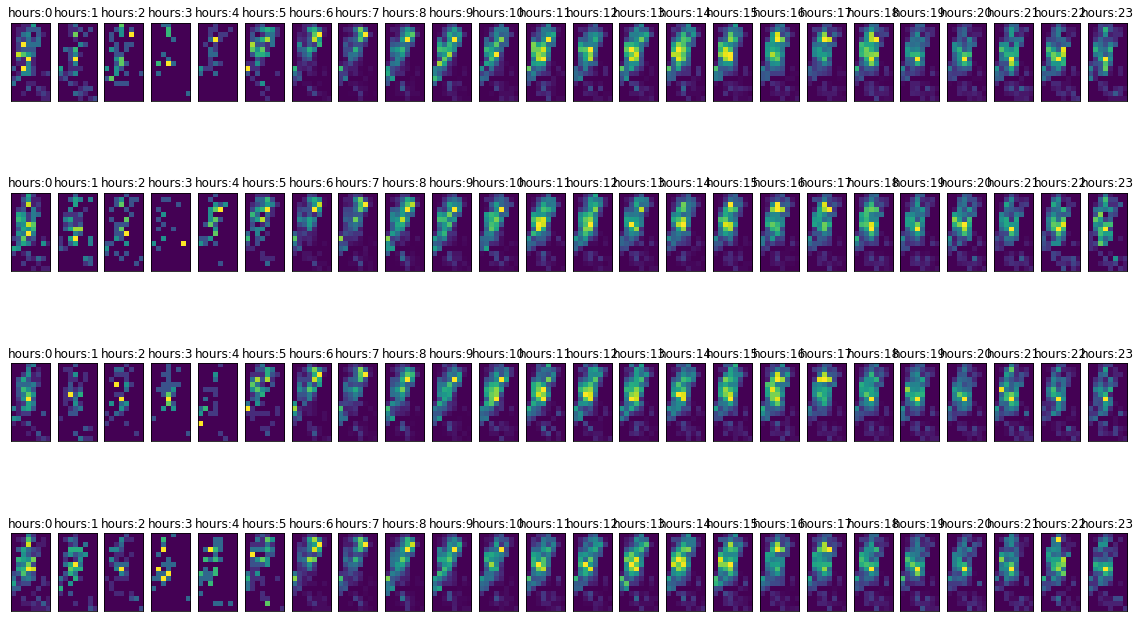

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
T = 1 # Cycle. In one week, one cycle is 24*7 hours
oclock = 0 # time o'clock (1-24) on one day
fig = plt.figure(figsize=(20,12))
len_display = 96 # The sequence number you wanna display.
for idx in range(len_display):  
    ax = fig.add_subplot(4, 24, idx+1) # this line adds sub-axes
    h = idx%24
    ax.set_title('hours:'+str(h))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(Y_train[oclock+idx*T][0]) # this line creates the image using the pre-defined sub axes